# Mini Project - Team John Doe

In [3]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 59.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=033adb98f291f3b90af777b54e299dd2c9ce615dd4626fb807257777eaf475db
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [5]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
import findspark
findspark.init()

In [154]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [157]:
import os
os.getcwd()

'/content'

In [158]:
# Read data
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("/content/drive/MyDrive/Mini Project 2/XYZ_Bank_Deposit_Data_Classification.csv", sep=';')
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [159]:
# Show sample data
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [160]:
# Data Types of columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [161]:
# Renaming columns so that they can be used easily

df = df.withColumnRenamed("emp.var.rate", "emp_var_rate")\
        .withColumnRenamed("cons.price.idx", "cons_price_idx")\
        .withColumnRenamed("cons.conf.idx", "cons_conf_idx")\
        .withColumnRenamed("nr.employed","nr_employed")

## Exploratory Data Analysis

In [162]:
# Checking for Null Values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().transpose()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [163]:
# Check basic statistics
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934036,17,98
job,41188,None,None,admin.,unknown
marital,41188,None,None,divorced,unknown
education,41188,None,None,basic.4y,unknown
default,41188,None,None,no,yes
housing,41188,None,None,no,yes
loan,41188,None,None,no,yes
contact,41188,None,None,cellular,telephone
month,41188,None,None,apr,sep


In [164]:
# Target variable Distribution
df.groupBy("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [165]:
# Finding categorical variables

cat_features = [t[0] for t in df.dtypes if t[1] == 'string']

# checking value count of each category
for i in cat_features:
    df.groupBy(i).count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  9

In [166]:
# We could see 'unknown' as category in multiple variables. Checking count of missing values

cat_missing_values = pd.DataFrame(columns = ['column_name','Number_of_missing_values'])
for c in cat_features:
    x = df.select(c).where(df[c] =='unknown').count()
    cat_missing_values = cat_missing_values.append({'column_name' : c, 'Number_of_missing_values' : x},
            ignore_index = True)
    
cat_missing_values

,column_name,Number_of_missing_values
0,job,330
1,marital,80
2,education,1731
3,default,8597
4,housing,990
5,loan,990
6,contact,0
7,month,0
8,day_of_week,0
9,poutcome,0


In [167]:
# Imputing Unknown values in marital status with mode

marital_mode = df.groupby("marital").count().orderBy("count", ascending=False).first()[0]
df=df.withColumn("marital",when(df.marital=='unknown',marital_mode).otherwise(df.marital))

In [168]:
# Showing value counts
df.groupBy('marital').count().show()

+--------+-----+
| marital|count|
+--------+-----+
|divorced| 4612|
| married|25008|
|  single|11568|
+--------+-----+



In [169]:
# Combining 'illiterate' and 'unknown' category together in education column

df = df.withColumn("education",when(df.education=='illiterate','unknown').otherwise(df.education))

# Similarly, for default column, combining 'yes' and 'unknown' together

df = df.withColumn("default",when(df.default=='yes','unknown').otherwise(df.default))

# Checking the dataset
df.groupBy('default').count().show()

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8600|
|     no|32588|
+-------+-----+



In [170]:
# Adding age label

from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[15, 26, 36, 46, 56, 66, 76, 100],inputCol="age", outputCol="age_buckets")
df = bucketizer.setHandleInvalid("keep").transform(df)


In [171]:
df.select('age', 'age_buckets').show()

+---+-----------+
|age|age_buckets|
+---+-----------+
| 56|        4.0|
| 57|        4.0|
| 37|        2.0|
| 40|        2.0|
| 56|        4.0|
| 45|        2.0|
| 59|        4.0|
| 41|        2.0|
| 24|        0.0|
| 25|        0.0|
| 41|        2.0|
| 25|        0.0|
| 29|        1.0|
| 57|        4.0|
| 35|        1.0|
| 54|        3.0|
| 35|        1.0|
| 46|        3.0|
| 50|        3.0|
| 39|        2.0|
+---+-----------+
only showing top 20 rows



In [172]:
t = {0.0:"15-25", 1.0: "26-35", 2.0:"36-45", 3.0: "46-55", 4.0: "56-65", 5.0: "66-75", 6.0: "Above 75"}
udf_foo = udf(lambda x: t[x], StringType())
df = df.withColumn("age_label", udf_foo("age_buckets"))

In [173]:
df.select('age', 'age_buckets', 'age_label').show()

+---+-----------+---------+
|age|age_buckets|age_label|
+---+-----------+---------+
| 56|        4.0|    56-65|
| 57|        4.0|    56-65|
| 37|        2.0|    36-45|
| 40|        2.0|    36-45|
| 56|        4.0|    56-65|
| 45|        2.0|    36-45|
| 59|        4.0|    56-65|
| 41|        2.0|    36-45|
| 24|        0.0|    15-25|
| 25|        0.0|    15-25|
| 41|        2.0|    36-45|
| 25|        0.0|    15-25|
| 29|        1.0|    26-35|
| 57|        4.0|    56-65|
| 35|        1.0|    26-35|
| 54|        3.0|    46-55|
| 35|        1.0|    26-35|
| 46|        3.0|    46-55|
| 50|        3.0|    46-55|
| 39|        2.0|    36-45|
+---+-----------+---------+
only showing top 20 rows



In [174]:
df_P = df.toPandas()

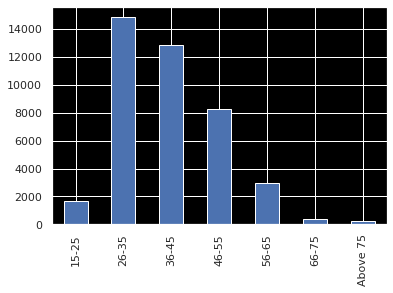

In [175]:
df_P['age_label'].value_counts().reindex(["15-25",  "26-35", "36-45",  "46-55", "56-65",  "66-75", "Above 75"]).plot(kind='bar')

In [176]:
df = df.drop(*['age','age_label'])

In [177]:
# Binning number of days last contacted

# First checking the distribution of Pdays
pdays_values = df.select('pdays').distinct().rdd.map(lambda r: r[0]).collect()
pdays_values.sort()
print(pdays_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 999]


In [178]:
# Adding pdays buckets

from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[0, 6, 11, 16, 21, 30, 1000],inputCol="pdays", outputCol="pdays_buckets")
df = bucketizer.setHandleInvalid("keep").transform(df)

In [179]:
# Adding pdays label
t = {0.0:"Less than 5 days", 1.0: "6-10 days", 2.0:"11-15 days", 3.0: "16-20 days", 4.0: "More than 20 days", 5.0: "Never"}
udf_foo = udf(lambda x: t[x], StringType())
df = df.withColumn("pdays_label", udf_foo("pdays_buckets"))

In [180]:
df = df.drop(*['pdays','pdays_buckets'])

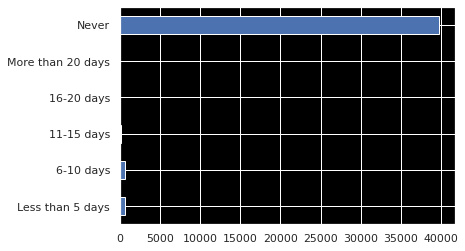

In [181]:
df_P = df.toPandas()
df_P['pdays_label'].value_counts().reindex(["Less than 5 days", "6-10 days", "11-15 days",  "16-20 days", "More than 20 days", "Never"]).plot(kind='barh')

In [182]:
df.groupBy('pdays_label').count().show()

+-----------------+-----+
|      pdays_label|count|
+-----------------+-----+
| Less than 5 days|  705|
|       11-15 days|  166|
|        6-10 days|  606|
|            Never|39673|
|       16-20 days|   30|
|More than 20 days|    8|
+-----------------+-----+



In [183]:
# Getting numeric features
int_features = [t[0] for t in df.dtypes if t[1] == 'int']
double_features =  [t[0] for t in df.dtypes if t[1] == 'double']
numeric_features = int_features + double_features
numeric_features

numeric_features_df = df.select(numeric_features)

In [184]:
# Finding correlation between all numeric features

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,age_buckets
duration,1.000000,-0.071699,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,-0.001734
campaign,-0.071699,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,0.005480
previous,0.020640,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.022667
emp_var_rate,-0.027968,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,0.002832
cons_price_idx,0.005312,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,0.005568
cons_conf_idx,-0.008173,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.122955
euribor3m,-0.032897,0.135133,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,0.013480
nr_employed,-0.044703,0.144095,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.014009
age_buckets,-0.001734,0.005480,0.022667,0.002832,0.005568,0.122955,0.013480,-0.014009,1.000000


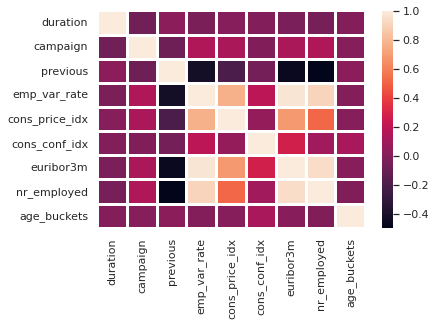

In [185]:
# Creating correlation heatmap
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.heatmap(corr_df, linewidth = 2)


In [186]:
# Dropping highly correlated variables
cols = ['emp_var_rate', 'euribor3m']
df = df.drop(*cols)

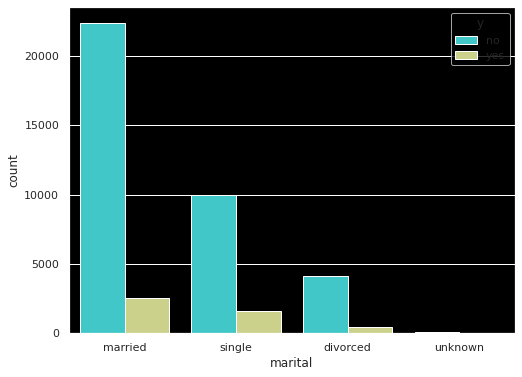

In [42]:
# Marital staus with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'marital',data=df_P, palette='rainbow',hue='y')

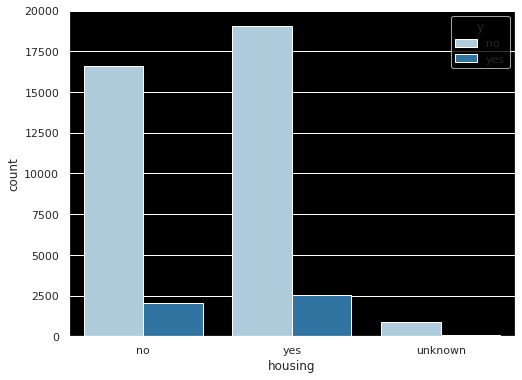

In [43]:
# Housing staus with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'housing',data=df_P, palette='Paired',hue='y')

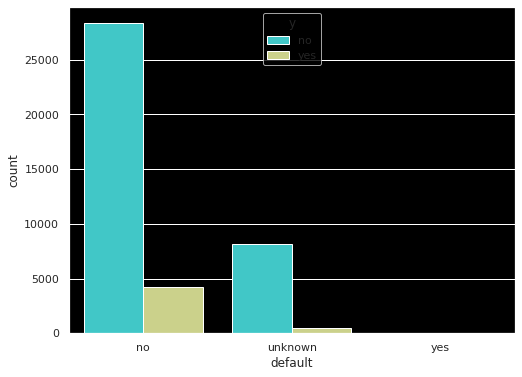

In [44]:
# Bank default status with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'default',data=df_P, palette='rainbow',hue='y')

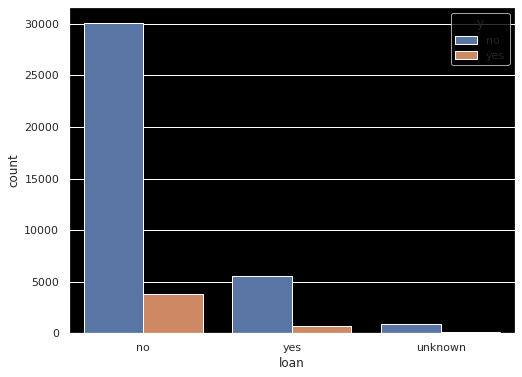

In [45]:
# Loan status

plt.figure(figsize=(8,6))
sns.countplot(x= 'loan',data=df_P,hue='y')

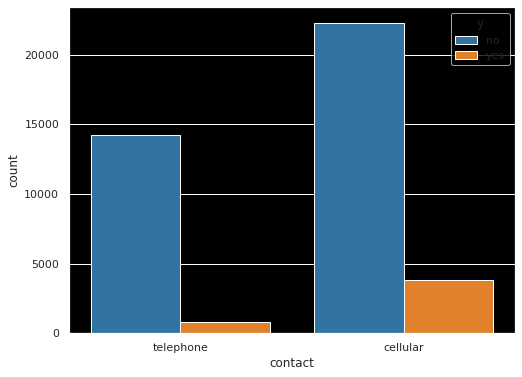

In [46]:
# Marital staus with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'contact',data=df_P, palette='tab10',hue='y')

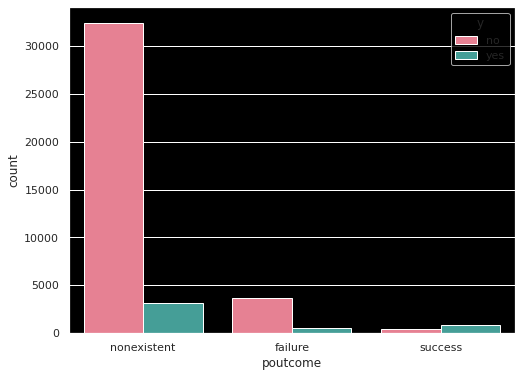

In [47]:
# Marital staus with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'poutcome',data=df_P, palette='husl',hue='y')

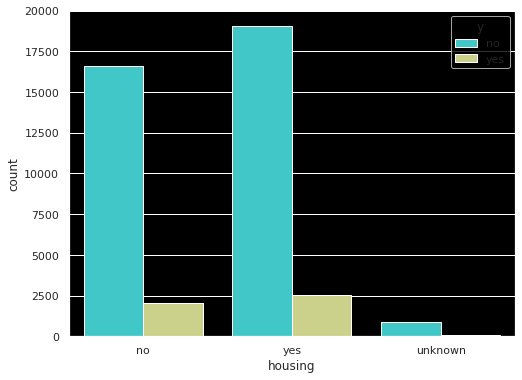

In [48]:
# Marital staus with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'housing',data=df_P, palette='rainbow',hue='y')

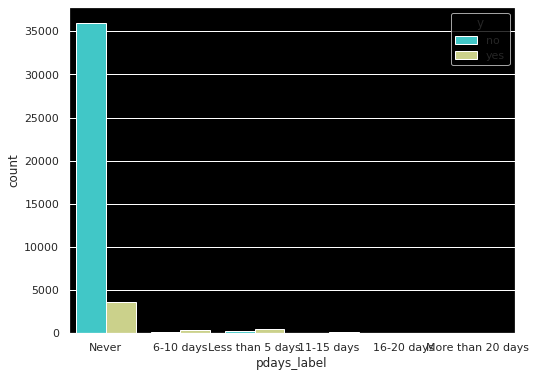

In [49]:
# pdays with target variable
plt.figure(figsize=(8,6))
sns.countplot(x= 'pdays_label',data=df_P, palette='rainbow',hue='y')

In [50]:
df.crosstab('job','y').toPandas().set_index('job_y').transpose()

job_y,housemaid,services,self-employed,student,retired,unknown,admin.,blue-collar,technician,entrepreneur,management,unemployed
no,954,3646,1272,600,1286,293,9070,8616,6013,1332,2596,870
yes,106,323,149,275,434,37,1352,638,730,124,328,144


In [51]:
df.crosstab('education','y').toPandas().set_index('education_y').transpose()

education_y,basic.9y,basic.4y,high.school,unknown,basic.6y,professional.course,university.degree,illiterate
no,5572,3748,8484,1480,2104,4648,10498,14
yes,473,428,1031,251,188,595,1670,4


In [52]:
df.crosstab('month','y').toPandas().set_index('month_y').transpose()

month_y,jul,nov,apr,oct,sep,jun,mar,aug,dec,may
no,6525,3685,2093,403,314,4759,270,5523,93,12883
yes,649,416,539,315,256,559,276,655,89,886


In [53]:
df.crosstab('day_of_week','y').toPandas().set_index('day_of_week_y').transpose()

day_of_week_y,mon,thu,tue,fri,wed
no,7667,7578,7137,6981,7185
yes,847,1045,953,846,949


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


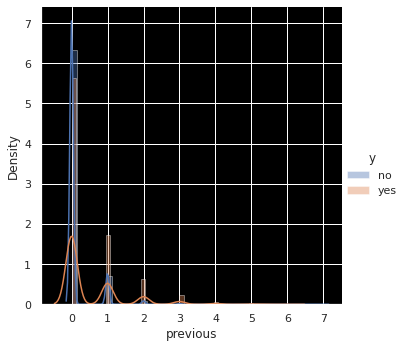

In [187]:
# Univariate analysis of numeric variable
df_P = df.toPandas()
sns.FacetGrid(df_P , hue ='y', size=5).map(sns.distplot, "previous").add_legend()

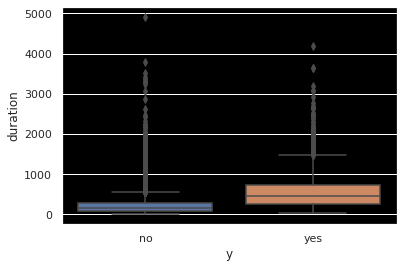

In [188]:
sns.boxplot(x = 'y', y = 'duration', data=df_P)
plt.show()

In [54]:
df1 = df.toPandas()
df1.to_csv('cleaned_df.csv')

## Modelling

### Data Preparation

In [140]:
## Reading processed dataset

df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("/content/drive/MyDrive/Mini Project 2/final_data.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 


There are 41188 rows 19 columns in the data.


In [141]:
# Numeric variables
numeric_features = [feature[0] for feature in df.dtypes if (feature[1] == 'int' or feature[1] == 'double')]
print(numeric_features)
# Cateogrical variables
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
categorical_features.remove('y')
print(categorical_features)

['duration', 'campaign', 'previous', 'cons_price_idx', 'cons_conf_idx', 'nr_employed', 'age_buckets']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays_label']


In [142]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler

categoricalColumns = categorical_features
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]

numericCols = numeric_features
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]



scaler = StandardScaler(inputCol = "features",
                        outputCol = "scaledFeatures",
                        withStd = True,
                        withMean = True)
stages += [scaler]

In [143]:
cols = df.columns
cols.remove('y')
cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'previous',
 'poutcome',
 'cons_price_idx',
 'cons_conf_idx',
 'nr_employed',
 'age_buckets',
 'pdays_label']

In [144]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'scaledFeatures']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- scaledFeatures: vector (nullable = true)



In [145]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
scaledFeatures,"[-0.5820157595057507, -0.5383104552835672, -0....","[-0.5820157595057507, -0.5383104552835672, -0....","[-0.5820157595057507, -0.5383104552835672, -0....","[1.7181248183605764, -0.5383104552835672, -0.4...","[-0.5820157595057507, -0.5383104552835672, -0...."


In [146]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28833
Test Dataset Count: 12355


## Logistic Regression

In [63]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

evaluator = BinaryClassificationEvaluator()

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'label', maxIter=10)

lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.25])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

lrevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName = "areaUnderROC")

# Create 5-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = lrevaluator,
                    numFolds = 5)

lrcvModel = lrcv.fit(train)
print(lrcvModel)

lrpredictions = lrcvModel.transform(test)

print('Accuracy:', lrevaluator.evaluate(lrpredictions))
print('AUC:', BinaryClassificationMetrics(lrpredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(lrpredictions['label','prediction'].rdd).areaUnderPR)
# lrModel = lr.fit(train)

# lrpredictions = lrModel.transform(test)
# trainingSummary = lrModel.summary

# print("Test Area Under ROC: " + str(evaluator.evaluate(lrpredictions, {evaluator.metricName: "areaUnderROC"})))

CrossValidatorModel_b46a9913f5f4
Accuracy: 0.9385966990280151


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


AUC: 0.8062668033207533
PR: 0.2992639894612505


## Decision tree

In [66]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'label', maxDepth = 3)

dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.maxBins, [10, 20])
             .build())

dtevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 5)

dtcvModel = dtcv.fit(train)
print(dtcvModel)

dtpredictions = dtcvModel.transform(test)
#predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


print('Accuracy:', dtevaluator.evaluate(dtpredictions))
print('AUC:', BinaryClassificationMetrics(dtpredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(dtpredictions['label','prediction'].rdd).areaUnderPR)

CrossValidatorModel_cc251adbf8a4
Accuracy: 0.8224819363390667
AUC: 0.802763583657338
PR: 0.37598035635845994


## Random Forest Classifier

In [68]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")

rfparamGrid = (ParamGridBuilder()

               .addGrid(rf.maxDepth, [2, 5, 10])

               .addGrid(rf.maxBins, [5, 10, 20])

               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

rfevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

rfcvModel = rfcv.fit(train)
print(rfcvModel)

rfpredictions = rfcvModel.transform(test)

print('Accuracy:', rfevaluator.evaluate(rfpredictions))
print('AUC:', BinaryClassificationMetrics(rfpredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(rfpredictions['label','prediction'].rdd).areaUnderPR)

CrossValidatorModel_bfdab30268a1
Accuracy: 0.9413142530328694
AUC: 0.8259026756651459
PR: 0.2639758123030512


## Gradient-Boosted Tree Classifier

In [69]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gb = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")

gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5])
             .addGrid(gb.maxBins, [10, 20])
             .addGrid(gb.maxIter, [5, 10])
             .build())

gbevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 5-fold CrossValidator
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 5)

gbcvModel = gbcv.fit(train)
print(gbcvModel)

gbpredictions = gbcvModel.transform(test)

print('Accuracy:', gbevaluator.evaluate(gbpredictions))
print('AUC:', BinaryClassificationMetrics(gbpredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(gbpredictions['label','prediction'].rdd).areaUnderPR)

CrossValidatorModel_d79681a181e0
Accuracy: 0.9450036171576403
AUC: 0.8058665721544137
PR: 0.4114150568972306


## Linear Support Vector Classification

In [75]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(featuresCol='scaledFeatures', \
                 labelCol='label')

lsvcparamGrid = (ParamGridBuilder()
             .addGrid(lsvc.maxIter, [10, 20])
             .addGrid(lsvc.regParam, [0.01, 0.1])
             .build())

lsvcevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create 5-fold CrossValidator
lsvccv = CrossValidator(estimator = lsvc,
                      estimatorParamMaps = lsvcparamGrid,
                      evaluator = lsvcevaluator,
                      numFolds = 5)

lsvcModel = lsvccv.fit(train)
print(lsvcModel)

lsvcpredictions = lsvcModel.transform(test)

print('Accuracy:', gbevaluator.evaluate(lsvcpredictions))
print('AUC:', BinaryClassificationMetrics(lsvcpredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(lsvcpredictions['label','prediction'].rdd).areaUnderPR)


CrossValidatorModel_987269e7e1b1
Accuracy: 0.9340574525422172


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


AUC: 0.7787659138609258
PR: 0.22276513840745887


## Confusion Matrix for Best model

In [88]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  417   986]
 [  150 10802]]


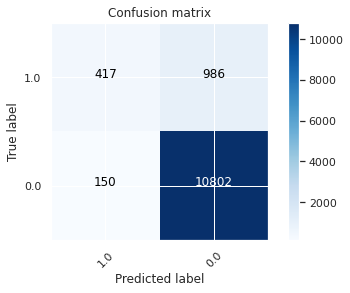

In [89]:
y_true = rfpredictions.select("label")
y_true = y_true.toPandas()

y_pred = rfpredictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

## ROC-AUC Plot

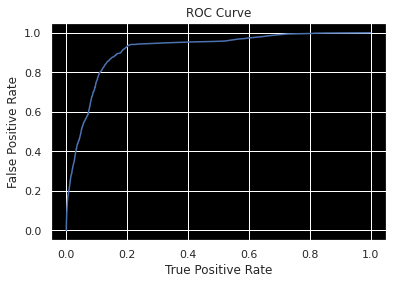

Training set areaUnderROC: 0.912952258623975


In [92]:
trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# K-means clustering

In [147]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='scaledFeatures', k=i)
    
    KMeans_fit=KMeans_algo.fit(df)
    
    output=KMeans_fit.transform(df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.15158322801319687
Silhouette Score: 0.0895306702752686
Silhouette Score: 0.15485066861124316
Silhouette Score: 0.1075634363545891
Silhouette Score: 0.10865610616736057
Silhouette Score: 0.11115960162660989
Silhouette Score: 0.11677307984281411
Silhouette Score: 0.09594631336755072


Text(0, 0.5, 'cost')

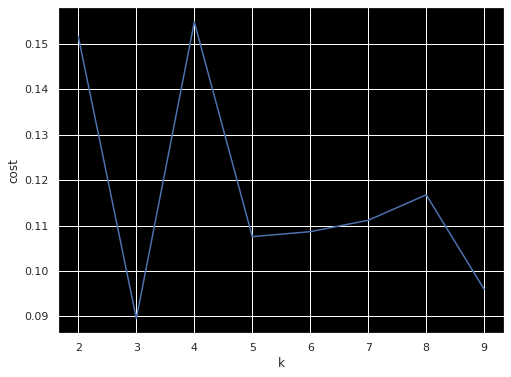

In [148]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [149]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

KMeans_=KMeans(featuresCol='scaledFeatures', k=4) 
KMeans_Model=KMeans_.fit(df)
KMeans_Assignments=KMeans_Model.transform(df)

In [150]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  546|
|         3|28695|
|         2|10509|
|         0| 1438|
+----------+-----+



In [151]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="scaledFeatures", outputCol="pca")
pca_model = pca.fit(df)
pca_transformed = pca_model.transform(df)



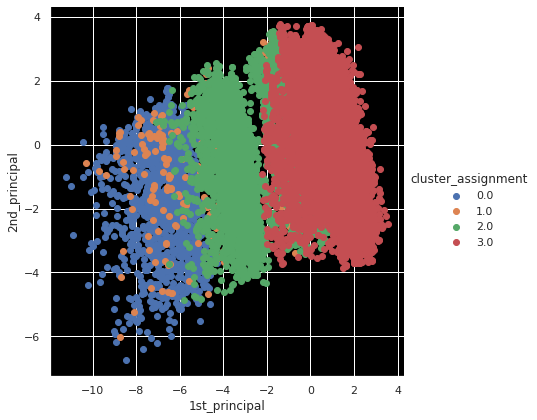

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

## Save and load model

In [118]:
bestModel = rfcvModel.bestModel
bestModel


rf1 = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures",numTrees=50)
rfModel1 = rf1.fit(train)
rfModel1.save("/finalModel")
pipelineModel = rfModel1.load("/finalModel")
train = pipelineModel.transform(train)


In [122]:
rfModel1.save("/content/drive/MyDrive/Mini Project 2/ChampionModel")




## Feature Importance

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
rfModel = rf.fit(train)

## Gini-Based Method for Gradient Boosted Tree
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
  
  
#ExtractFeatureImportance(model.stages[-1].featureImportances, dataset, "features")
dataset_fi = ExtractFeatureImportance(rfModel.featureImportances, df, "scaledFeatures")
dataset_fi = sqlContext.createDataFrame(dataset_fi)
display(dataset_fi)

dataset_fi_pd = dataset_fi.toPandas()
dataset_fi_pd.head(10)